# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
# 1) Імпортуємо pandas
import pandas as pd

# 2) Завантажуємо датасет
df = pd.read_csv('train.csv')

# 3) Перші 5 рядків
display(df.head())

# 4) Основна інформація: кількість записів, типи колонок, пропуски
df.info()

# 5) Статистика по числовим полям
display(df.describe())

# 6) Кількість пропущених значень у кожній колонці
display(df.isnull().sum())

# 7) Видаляємо всі рядки з пропущеними значеннями
df = df.dropna()

# 8) Перевірка: скільки записів залишилось
print(f"Після dropna: {df.shape[0]} рядків, {df.shape[1]} колонок")

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,6f7127d9d7,All this flirting going on - The ATG smiles...,good,neutral
freq,1,1,199,11118


,0
textID,0
text,1
selected_text,1
sentiment,0


Після dropna: 27480 рядків, 4 колонок


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



Кількість записів у кожному класі:
sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64


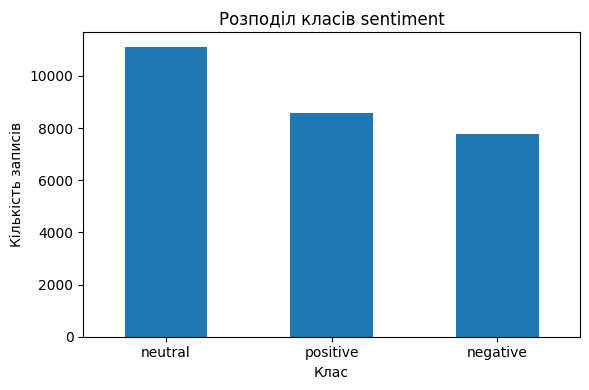


Статистика по довжинам текстів:
count    27480.000000
mean        68.330022
std         35.603870
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: text_length, dtype: float64


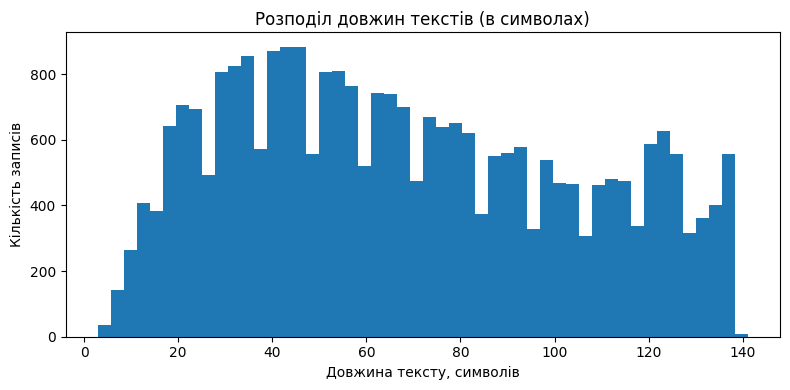


Найбільш типова довжина тексту (мода): 41 символів


In [2]:
import matplotlib.pyplot as plt

# Аналіз кількості класів
class_counts = df['sentiment'].value_counts()
print("Кількість записів у кожному класі:")
print(class_counts)

# Візуалізація розподілу класів
plt.figure(figsize=(6,4))
class_counts.plot(kind='bar')
plt.title('Розподіл класів sentiment')
plt.xlabel('Клас')
plt.ylabel('Кількість записів')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Обчислення довжини кожного тексту в символах
df['text_length'] = df['text'].astype(str).apply(len)

# Основна статистика по довжинах
print("\nСтатистика по довжинам текстів:")
print(df['text_length'].describe())

# Візуалізація розподілу довжин текстів
plt.figure(figsize=(8,4))
plt.hist(df['text_length'], bins=50)
plt.title('Розподіл довжин текстів (в символах)')
plt.xlabel('Довжина тексту, символів')
plt.ylabel('Кількість записів')
plt.tight_layout()
plt.show()

# Додатково: знайдемо найчастіший діапазон або точкову моду
most_common_length = df['text_length'].mode()[0]
print(f"\nНайбільш типова довжина тексту (мода): {most_common_length} символів")

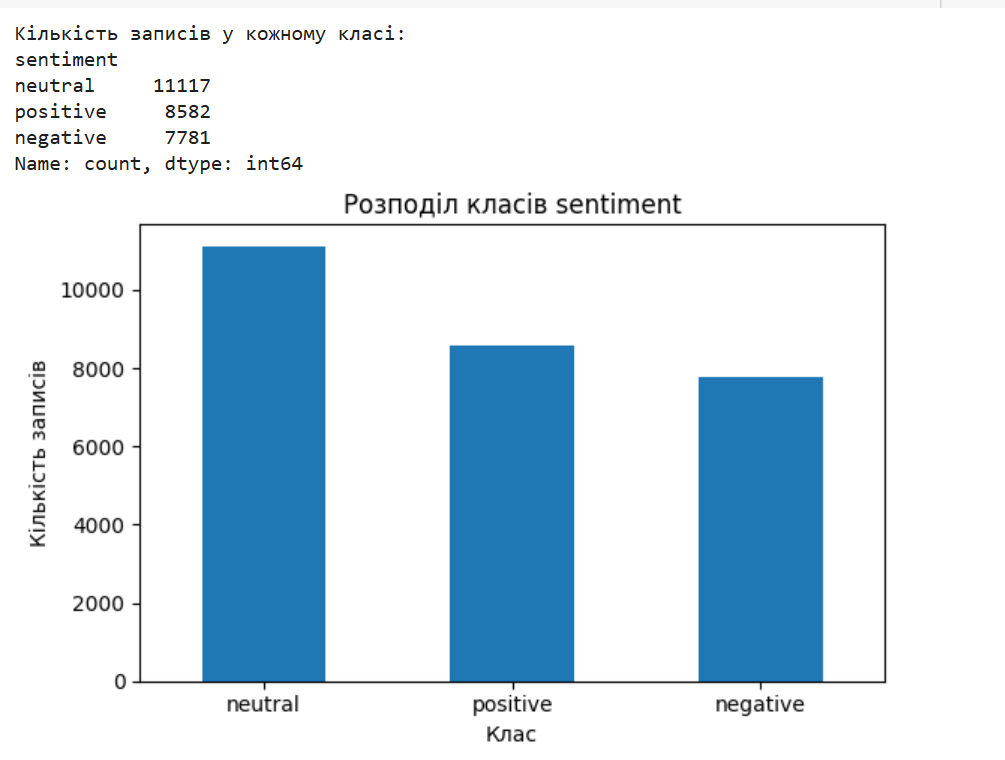

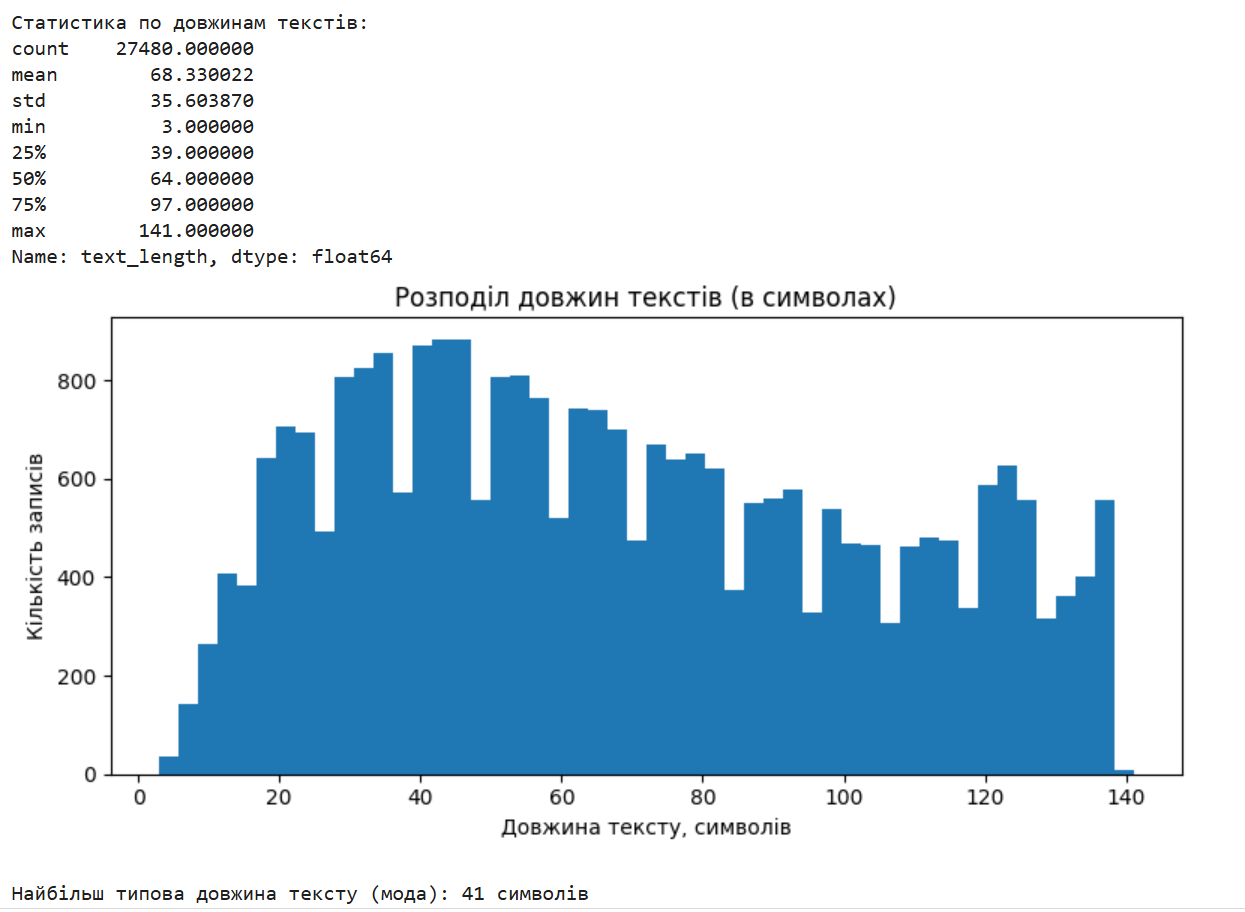

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [6]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer


In [12]:
import nltk
import numpy as np

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# Підготуємо стоп-слова і стеммер
stop_words = set(stopwords.words('english'))
stemmer    = SnowballStemmer('english')

# Функція токенізації + стемінгу
def tokenize_and_stem(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text.lower())
    tokens = text.split()
    return [
        stemmer.stem(tok)
        for tok in tokens
        if tok not in stop_words and len(tok) > 1
    ]

MAX_FEATURES = 5000

# Ініціалізуємо CountVectorizer з нашим токенізатором
vectorizer = CountVectorizer(
    tokenizer    = tokenize_and_stem,
    lowercase    = False,
    max_features = MAX_FEATURES,
    min_df       = 5,
    max_df       = 0.8
)

# Підганяємо векторизатор і будуємо матрицю документ-термін
X_bow = vectorizer.fit_transform(df['text'])

# Перевіряємо результати
print(f"Матриця BOW: {X_bow.shape[0]} документів × {X_bow.shape[1]} термінів")
print("Перші 10 термінів словника:", vectorizer.get_feature_names_out()[:10])

# можна подивитися частотність термінів:
term_freq = np.asarray(X_bow.sum(axis=0)).ravel()
freq_df   = pd.DataFrame({
    'term':   vectorizer.get_feature_names_out(),
    'count':  term_freq
}).sort_values('count', ascending=False)

print("\nТоп-10 найчастіших термінів:")
print(freq_df.head(10))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Матриця BOW: 27480 документів × 3722 термінів
Перші 10 термінів словника: ['aaaah' 'aah' 'ab' 'abandon' 'abbi' 'abil' 'abit' 'abl' 'absolut' 'abt']

Топ-10 найчастіших термінів:
       term  count
826     day   2497
1357     go   2384
1328    get   1918
1369   good   1600
3636   work   1530
1946   love   1486
1893   like   1462
1590   http   1247
3304  today   1155
3292   time   1104


### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1) Визначаємо X та y
X = X_bow
y = df['sentiment']

# 2) Розбиття на train/test (80/20) зі стратифікацією по мітках
X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3) Словник моделей для перевірки
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree':      DecisionTreeClassifier(random_state=42),
    'RandomForest':      RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting':  GradientBoostingClassifier(random_state=42)
}

# 4) Навчання, прогноз і оцінка
results = {}
for name, model in models.items():
    model.fit(X_train_bow, y_train)
    y_pred = model.predict(X_test_bow)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} — Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))
    results[name] = acc

# 5) Визначаємо найкращу модель за Accuracy
best_model = max(results, key=results.get)
print(f"\nНайкраща модель: {best_model} з Accuracy = {results[best_model]:.4f}")


LogisticRegression — Accuracy: 0.6881
              precision    recall  f1-score   support

    negative     0.7046    0.6330    0.6669      1556
     neutral     0.6332    0.7143    0.6713      2223
    positive     0.7604    0.7041    0.7312      1717

    accuracy                         0.6881      5496
   macro avg     0.6994    0.6838    0.6898      5496
weighted avg     0.6931    0.6881    0.6888      5496


DecisionTree — Accuracy: 0.6366
              precision    recall  f1-score   support

    negative     0.6071    0.6395    0.6228      1556
     neutral     0.6257    0.5879    0.6062      2223
    positive     0.6770    0.6971    0.6869      1717

    accuracy                         0.6366      5496
   macro avg     0.6366    0.6415    0.6387      5496
weighted avg     0.6364    0.6366    0.6361      5496


RandomForest — Accuracy: 0.6914
              precision    recall  f1-score   support

    negative     0.6898    0.6375    0.6627      1556
     neutral     0.6662 

За результатами:

Найкраща модель – RandomForest із точністю ≈0.691.

Зважена та макро-середня F1-міра теж близько 0.69, що вказує на збалансовану, але не дуже високу здатність моделі відрізняти всі три класи.

У розподілі по класах:

Для negative recall ≈ 0.64 (близько 36% “негативних” пропущено),

Для neutral recall ≈ 0.68,

Для positive recall ≈ 0.75.

Висновок про якість:
~69 % accuracy для трьох класів «negative/neutral/positive» можна вважати середнім результатом для PoC. Модель явно вловлює “позитив” найкраще, але їй важко відрізняти «негатив» від «нейтрального» настрою. Загалом — базова робоча модель, але не “продакшн-якість”.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


Топ-20 найважливіших слів:


,term,importance
1946,love,0.026677
3239,thank,0.022248
1369,good,0.018347
2088,miss,0.014802
1469,happi,0.014350
2752,sad,0.013031
1405,great,0.009699
2997,sorri,0.009104
1570,hope,0.008547
2132,mother,0.008195



20 найменш важливих слів:


,term,importance
2974,solv,4.146321e-06
3140,suppli,3.828317e-06
3710,yt,3.726770e-06
1688,irish,3.654461e-06
1876,lemm,3.638978e-06
1934,loop,3.490337e-06
1875,leigh,3.344707e-06
2556,protect,3.112888e-06
509,cartoon,2.879496e-06
2611,rb,2.757756e-06


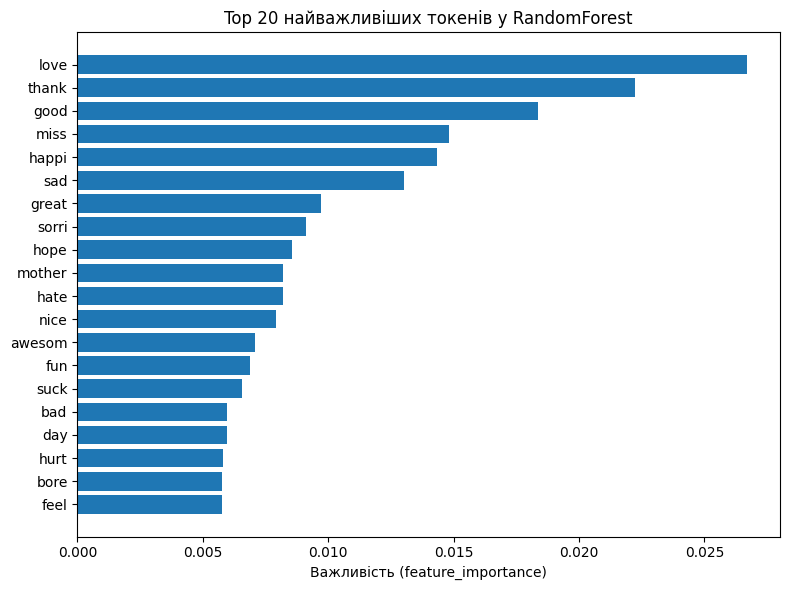

In [15]:
# 1) Витягуємо навчену модель RandomForest
rf = models['RandomForest']

# 2) Отримуємо імена фіч та їх важливості
feature_names = vectorizer.get_feature_names_out()
importances   = rf.feature_importances_

# 3) Створюємо DataFrame для сортування
imp_df = pd.DataFrame({
    'term':       feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# 4) Виводимо топ-20 найважливіших токенів
print("Топ-20 найважливіших слів:")
display(imp_df.head(20))

# 5) Виводимо 20 найменш важливих токенів
print("\n20 найменш важливих слів:")
display(imp_df.tail(20))

# 6) (За бажанням) Гістограма для візуалізації топ-20
plt.figure(figsize=(8,6))
plt.barh(imp_df.head(20)['term'][::-1], imp_df.head(20)['importance'][::-1])
plt.title('Top 20 найважливіших токенів у RandomForest')
plt.xlabel('Важливість (feature_importance)')
plt.tight_layout()
plt.show()

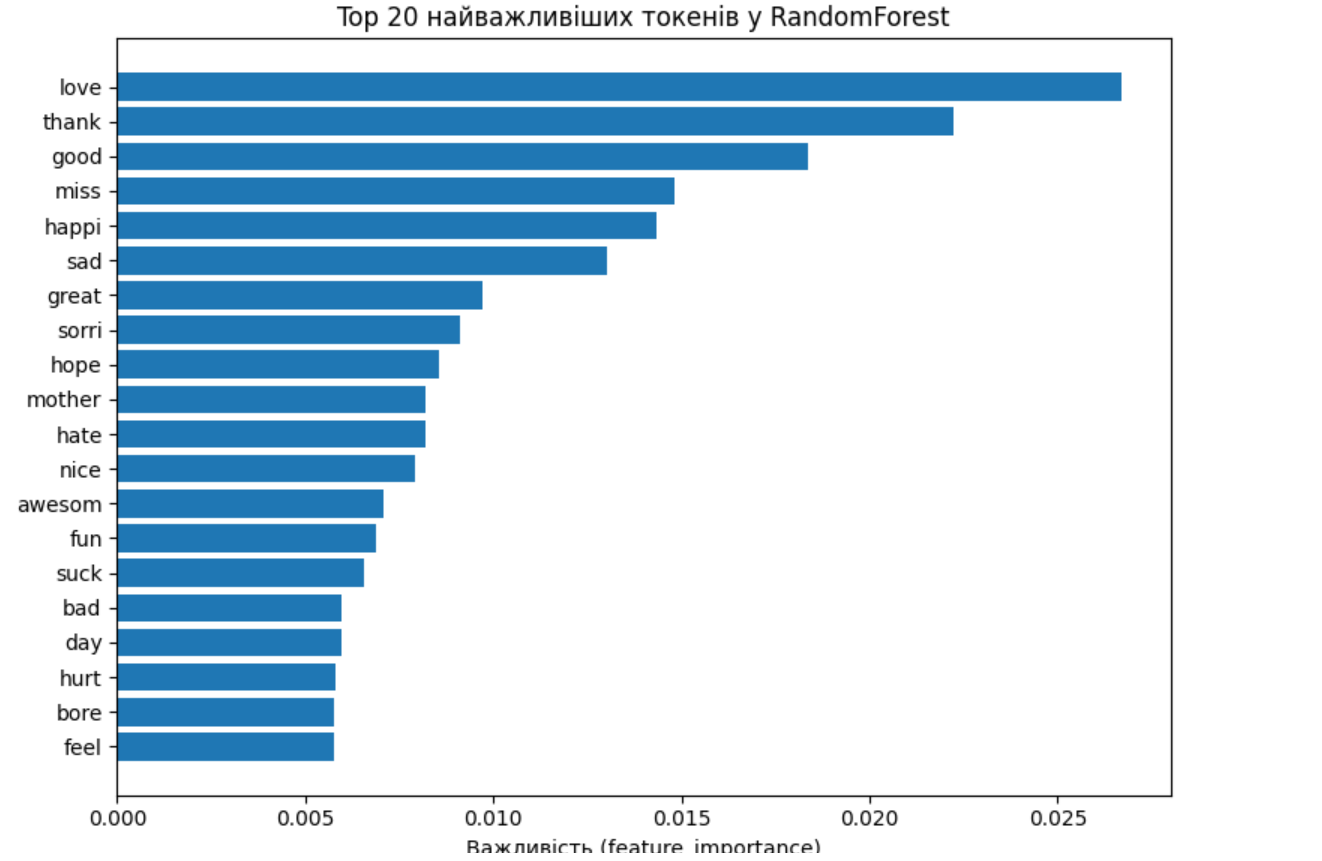

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1) Створюємо масив позиційних індексів
import numpy as np
indices = np.arange(X_bow.shape[0])

# 2) Відтворюємо розбиття, яке ми використовували для BOW
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=y,         # y = df['sentiment']
    random_state=42
)

# 3) Ініціалізуємо TF-IDF з тими ж параметрами та препроцесингом
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    tokenizer    = tokenize_and_stem,
    lowercase    = False,
    max_features = MAX_FEATURES,
    min_df       = 5,
    max_df       = 0.8
)

# 4) Навчаємо TF-IDF на всьому корпусі та трансформуємо
X_tfidf = tfidf.fit_transform(df['text'])

# 5) Формуємо train/test вибірки за позиціями
X_train_tfidf = X_tfidf[train_idx]
X_test_tfidf  = X_tfidf[test_idx]
y_train       = y.iloc[train_idx]
y_test        = y.iloc[test_idx]

# 6) Тренуємо RandomForest та оцінюємо якість
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tfidf.fit(X_train_tfidf, y_train)

y_pred = rf_tfidf.predict(X_test_tfidf)
print("TF-IDF + RF — Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

# 7) Аналіз важливості токенів
import pandas as pd
feat_names = tfidf.get_feature_names_out()
importances = rf_tfidf.feature_importances_
imp_df = pd.DataFrame({
    'term': feat_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Топ-20 важливих токенів (TF-IDF):")
print(imp_df.head(20))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF + RF — Accuracy: 0.6997816593886463
              precision    recall  f1-score   support

    negative     0.7179    0.6395    0.6764      1556
     neutral     0.6592    0.7058    0.6817      2223
    positive     0.7410    0.7467    0.7438      1717

    accuracy                         0.6998      5496
   macro avg     0.7061    0.6973    0.7007      5496
weighted avg     0.7014    0.6998    0.6996      5496

Топ-20 важливих токенів (TF-IDF):
        term  importance
1946    love    0.026992
3239   thank    0.022104
1369    good    0.019666
1469   happi    0.015206
2088    miss    0.015106
2752     sad    0.013041
1405   great    0.009807
2997   sorri    0.009250
1570    hope    0.009058
2218    nice    0.008247
1479    hate    0.008171
2132  mother    0.008099
1294     fun    0.007403
214   awesom    0.007265
826      day    0.007006
3121    suck    0.006596
1175    feel    0.006514
234      bad    0.006346
1357      go    0.006203
380     bore    0.005888


### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [18]:
# 1) Знаходимо індекси помилково класифікованих документів у тесті
mis_positions = np.where(y_pred != y_test.values)[0]
mis_idx       = [test_idx[pos] for pos in mis_positions]

# 2) Формуємо таблицю помилок
errors_df = pd.DataFrame({
    'textID': df.loc[mis_idx, 'textID'],
    'text':   df.loc[mis_idx, 'text'],
    'true':   y_test.values[mis_positions],
    'pred':   y_pred[mis_positions]
}, index=mis_idx)

# 3) Виводимо випадкові 10 прикладів помилок для огляду
display(errors_df.sample(10, random_state=42))

# 4) Розподіл типів помилок
print("\nКількість помилок за парами (справжній → прогноз):")
print(errors_df.groupby(['true','pred']).size().unstack(fill_value=0))

,textID,text,true,pred
24919,32bb7b3961,I forgot I moved 100 east...make that 8 hours ...,negative,positive
12428,4105fed8e2,I CAN`T!!! My heart aches for her children I...,negative,neutral
23145,58e24db41d,they closed the voting...all u can vote for ...,neutral,positive
19113,4cb84b29aa,"1 more goal, Gila!! But his last game is again...",positive,neutral
7738,d849ca0fd6,try direct message to me here on twitter,positive,neutral
7426,b3aa4e4195,big now!!! Vanessa is going to be 3 in Septem...,negative,positive
16435,0b800ccc03,Spending a weekend doing nothing but being do...,positive,neutral
27381,b2f2828ebd,you know you lvoe me!,neutral,positive
14320,f302c1c568,"just got home, talk",neutral,positive
26208,b329d819dd,went to see the dentist. can`t eat and im star...,negative,neutral



Кількість помилок за парами (справжній → прогноз):
pred      negative  neutral  positive
true                                 
negative         0      447       114
neutral        320        0       334
positive        71      364         0


Найчастіше модель плутає:

negative → neutral (447 випадків)

neutral → positive (334) і neutral → negative (320)

positive → neutral (364)

Це свідчить, що алгоритм має труднощі з межовими виразами настрою — «злегка негативними» або «злегка позитивними» фразами, та не завжди вловлює інтонацію контексту.

Три шляхи поліпшення якості
Додати n-грами (біграми, триграми) у векторизацію
Поодинокі токени («good», «sad») — корисні, але контекстні сполучення («not good», «really sad») часто змінюють сенс. Включення біграм і триграм у TF-IDF дозволить захопити заперечення, інтенсивність та фразеологічні звороти, які зараз губляться.

Розширити ознаки лексиконом настрою
Додати до моделі кількісні фічі на основі класичних sentiment-лексиконів (VADER, SentiWordNet):

Полярність і інтенсивність слів із лексикону.

Показник кількості заперечних сполучень («not», «never»).
Це допоможе моделі краще враховувати загальний тон повідомлення окрім ваг слів із TF-IDF.

Перейти на контекстні ембеддінги (BERT, RoBERTa) та тонке донавчання
Підключити попередньо навчені трансформерні моделі:

Отримати sentence-embeddings (наприклад, через bert-base-uncased)

Провести тонке донавчання (fine-tuning) безпосередньо на вашому корпусі
Контекстні ембеддінги враховують порядок слів, тональні відтінки та сарказм, суттєво знижуючи кількість таких помилок на межі класів.

Впровадження цих кроків має зменшити число «незрозумілих» для моделі прикладів і підняти загальну точність класифікації.

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model